<a href="https://colab.research.google.com/github/derevoAM/EDP/blob/main/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 10
## Planning a Radar Tracking Mission for a Research UAV:
Filter Development across coordinate systems
---
Course - Experimental Data Processing

**Team 7 :** Dmitij Kosenkov, Mikhail Derevianchenko, Daniia Zinniatullina  
**Date :**  October 19, 2025

# Project description
This project is devoted to developing a tracking filter for a moving UAV where radar measurements are in polar coordinates
while the motion model is in Cartesian coordinates and analyzing filter's performance.

# Part 1. Mission Build: Designing the Tracking Filter

In first part we develop a tracking filter for a moving UAV. Initially, we generate trajectory in the Cartesian coordinate system, then generate true range D and azimuth $\beta$ based on trajectory, and generate measurements(D, $\beta$) and pseudo-measurements(x, y).

In [424]:
import numpy as np
import matplotlib.pyplot as plt

In [425]:


x_0 = np.array([13500 / np.sqrt(2), 13500 / np.sqrt(2)])
v_0 = np.array([-50, -45])
sigma_acc = 0.2
sigma_measur = 20
N = 26
dt = 2
time = np.arange(0, N * dt, dt)
np.random.seed(42)
sigma_D = 20
sigma_beta = 0.02

np.random.seed(42)

def generate_trajectory(x0, v0):
  trajectory = np.empty((N, 2))
  velocity = np.empty((N, 2))

  trajectory[0] = x0
  velocity[0] = v0

  for i in range(1, N):
    trajectory[i] = trajectory[i - 1] + velocity[i - 1] * dt
    velocity[i] = velocity[i - 1]

  return trajectory, velocity

def generate_observations(trajectory):
  D = np.sqrt(trajectory[:, 0] ** 2 + trajectory[:, 1] ** 2)
  beta = np.arctan2(trajectory[:, 0], trajectory[:, 1])
  return D, beta


def generate_measurements(D, beta):
  measurements = np.empty((D.size, 2))
  for i in range(N):
    measurements[i] = np.array([D[i] + np.random.normal(0, sigma_D), beta[i] + np.random.normal(0, sigma_beta)])
  return measurements

def generate_pseudo_measurements(measurements):
  pseudo_measurements = np.empty((N, 2))
  for i in range(N):
    pseudo_measurements[i] = np.array([measurements[i][0] * np.sin(measurements[i][1]),
                                       measurements[i][0] * np.cos(measurements[i][1])])
  return pseudo_measurements


traj, vel = generate_trajectory(x_0, v_0)
D, beta = generate_observations(traj)
measurements = generate_measurements(D, beta)
pseudo_measurements = generate_pseudo_measurements(measurements)


The plot of a motion in a polar coordinate system is illustrated below.

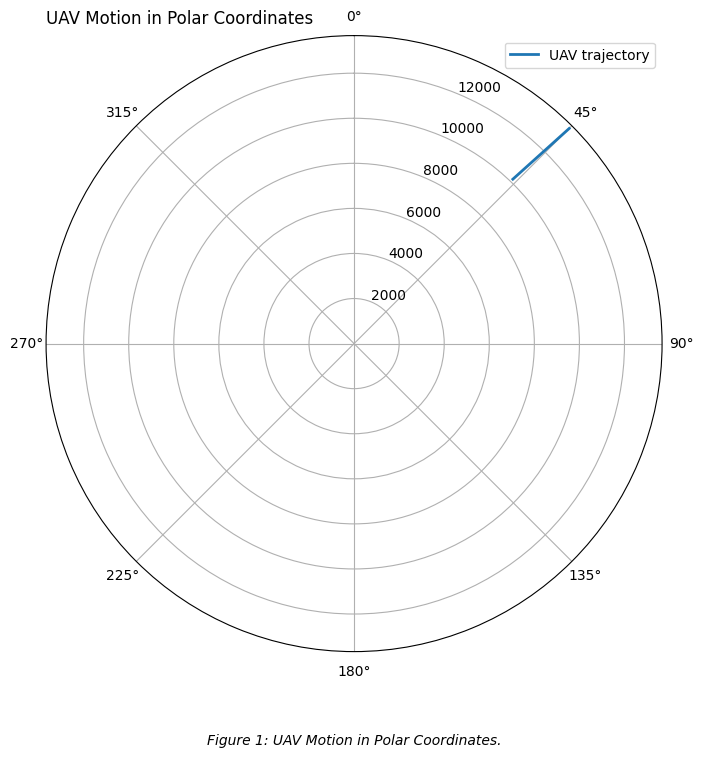

In [426]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection='polar')

ax.plot(beta, D, linewidth=2, label='UAV trajectory')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('UAV Motion in Polar Coordinates', va='bottom', loc='left')
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 1: UAV Motion in Polar Coordinates.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.show()

Also lets plot pseudo-measurements with true trajectory to check whether conversion between coordinate systems is correct.

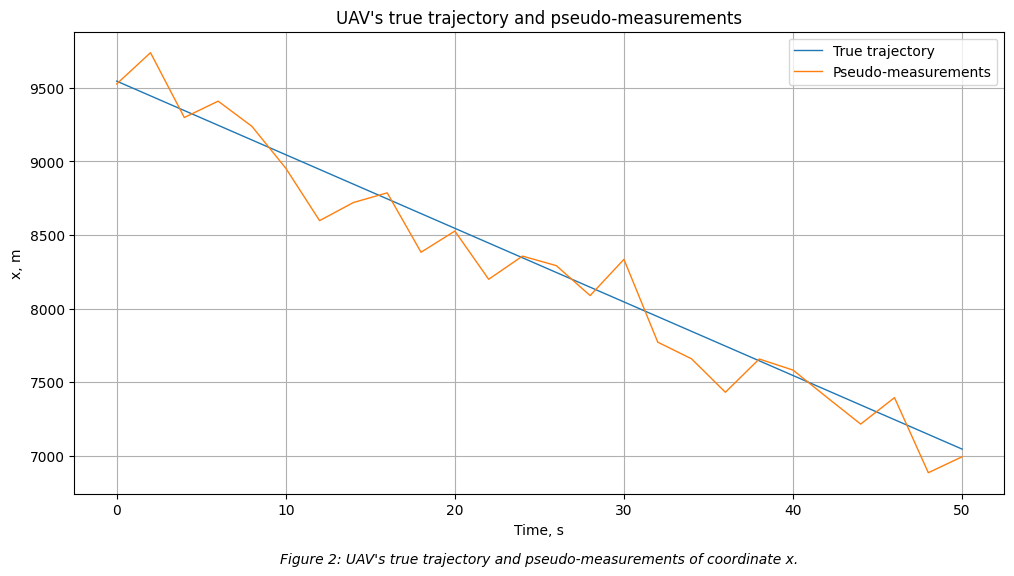

In [427]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, traj[:, 0], linewidth=1, alpha=1, label='True trajectory')
ax.plot(time, pseudo_measurements[:, 0], linewidth=1, alpha=1, label='Pseudo-measurements')
ax.set_xlabel('Time, s')
ax.set_ylabel('x, m')
ax.set_title("UAV's true trajectory and pseudo-measurements")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 2: UAV's true trajectory and pseudo-measurements of coordinate x.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Now it's time to develop the Kalman filter to estimate the state vecor X=[x, v_x, y, v_y].

In [428]:
class KalmanFilter:

  def __init__(self, F, H, P, X, measurements, pseudo_measurements, sigma_D,
  sigma_beta, N, m=None, R=None, G=None, Q=None):
    self.F = F
    self.G = G
    self.H = H
    self.Q = Q
    self.R = R
    self.P = P
    self.X_0 = X
    self.N = N
    self.P_predict_arr = np.zeros((self.N, self.P.shape[0], self.P.shape[0]))
    self.P_predict_arr[0] = P
    self.P_filter_arr = np.zeros((self.N, self.P.shape[0], self.P.shape[0]))
    self.P_filter_arr[0] = P
    self.P_filter = P
    self.P_predict = P
    self.X_predict = X
    self.X_filter = X
    self.S = np.zeros(self.N)
    self.measurements = measurements
    self.pseudo_measurements = pseudo_measurements
    self.filtered = np.zeros((self.N, self.X_0.size))
    self.predicted = np.zeros((self.N, self.X_0.size))
    self.sigma_D = sigma_D
    self.sigma_beta = sigma_beta
    self.filtered[0] = X
    self.predicted[0] = X
    self.polar_predicted = np.zeros((self.N, 2)) # D, beta
    self.polar_filtered = np.zeros((self.N, 2))
    self.R_arr = np.zeros((self.N, 2, 2))
    self.K_arr = np.zeros((self.N, 4, 2))


  def predict(self, i):
    self.X_predict = self.F @ self.X_filter
    self.P_predict = np.dot(np.dot(self.F, self.P_filter), self.F.T)




  def calc_R(self, i):
    R11 = np.sin(self.measurements[i][1]) ** 2 * self.sigma_D ** 2
    R11 += + (self.measurements[i][0] ** 2 * np.cos(self.measurements[i][1]) ** 2 * self.sigma_beta ** 2)
    R12 = np.sin(self.measurements[i][1]) * np.cos(self.measurements[i][1]) * (self.sigma_D ** 2 -
                                                                               self.measurements[i][0] ** 2 * self.sigma_beta ** 2)
    R21 = R12
    R22 = np.cos(self.measurements[i][1]) ** 2 * self.sigma_D ** 2
    R22 += self.measurements[i][0] ** 2 * np.sin(self.measurements[i][1]) ** 2 * self.sigma_beta ** 2

    return np.array([[R11, R12], [R21, R22]])

  def filtrate(self,i):
    self.R = self.calc_R(i)
    self.R_arr[i] = self.R
    self.S[i] = (self.H @ self.P_predict @ self.H.T + self.R)[0][0]

    self.K =  self.P_predict @ self.H.T @ np.linalg.inv(self.H @ self.P_predict @ self.H.T + self.R)
    self.P_filter = (np.identity(self.P.shape[0]) - self.K @ self.H) @  self.P_predict @ (np.identity(self.P.shape[0]) -
                                                                                          self.K @ self.H).transpose() + self.K @ self.R @ self.K.T
    self.X_filter = self.X_predict + self.K @ (self.pseudo_measurements[i] - self.H @ self.X_predict)
    self.K_arr[i] = self.K

    self.P_filter_arr[i] = self.P_filter
    self.P_predict_arr[i] = self.P_predict
    self.filtered[i] = self.X_filter
    self.predicted[i] = self.X_predict

    self.polar_predicted[i] = np.array([np.sqrt(self.X_predict[0] ** 2 + self.X_predict[2] ** 2),
                                        np.arctan2(self.X_predict[0], self.X_predict[2])])
    self.polar_filtered[i] = np.array([np.sqrt(self.X_filter[0] ** 2 + self.X_filter[2] ** 2),
                                       np.arctan2(self.X_filter[0], self.X_filter[2])])



  def filter_all(self):
    self.restart()
    for i in range(0, self.N):
      self.predict(i)
      self.filtrate(i)
    return self.filtered

  def restart(self):
    self.P_predict_arr = np.zeros((self.N, self.P.shape[0], self.P.shape[0]))
    self.P_predict_arr[0] = self.P
    self.P_filter_arr = np.zeros((self.N, self.P.shape[0], self.P.shape[0]))
    self.P_filter_arr[0] = self.P
    self.P_filter = self.P
    self.P_predict = self.P
    self.X_predict = self.X_0
    self.X_filter = self.X_0
    self.S = np.zeros(self.N)
    self.measurements = measurements
    self.filtered = np.zeros((self.N, self.X_0.size))
    self.predicted = np.zeros((self.N, self.X_0.size))
    self.sigma_acc = sigma_acc
    self.filtered[0] = self.X_0
    self.predicted[0] = self.X_0
    self.polar_predicted = np.zeros((self.N, 2)) # D, beta
    self.polar_filtered = np.zeros((self.N, 2))
    self.R_arr = np.zeros((self.N, 2, 2))

  def calc_residuals(self):
    self.residuals = np.zeros(self.N)
    for i in range(self.N):
      self.residuals[i] = self.measurements[i] - (self.H @ self.predicted[i])[0]
    return self.residuals

  def calc_biased_error(self):
    for i in range(1, self.N):
      self.mu_predict[i] = self.F @ self.mu[i - 1] + np.array([self.G[0][0], self.G[1][0]]) * self.q
      self.mu[i]  = (np.identity((self.K @ H).shape[0]) - self.K @ H) @ self.mu_predict[i]

  def calc_true_error(self):
    self.true_x = np.sqrt(self.P_filter_arr[:, 0, 0] + self.mu[:, 0]**2)
    self.true_v = np.sqrt(self.P_filter_arr[:, 1, 1] + self.mu[:, 1]**2)

We initialize Kalman filter:

In [429]:
X_0 = np.array([40000, -20, 40000, -20])
P_0 = 10 ** 10  * np.eye(4)
F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
R = np.array([sigma_measur**2])
filter = KalmanFilter(F,  H, P_0, X_0, measurements.copy(), pseudo_measurements.copy(), sigma_D, sigma_beta, N)
filtered_measur = filter.filter_all()

Lets check whether pseudo-measurements are filtered by plotting true trajectory, pseudo-measurements and filtered data of coordinate x.

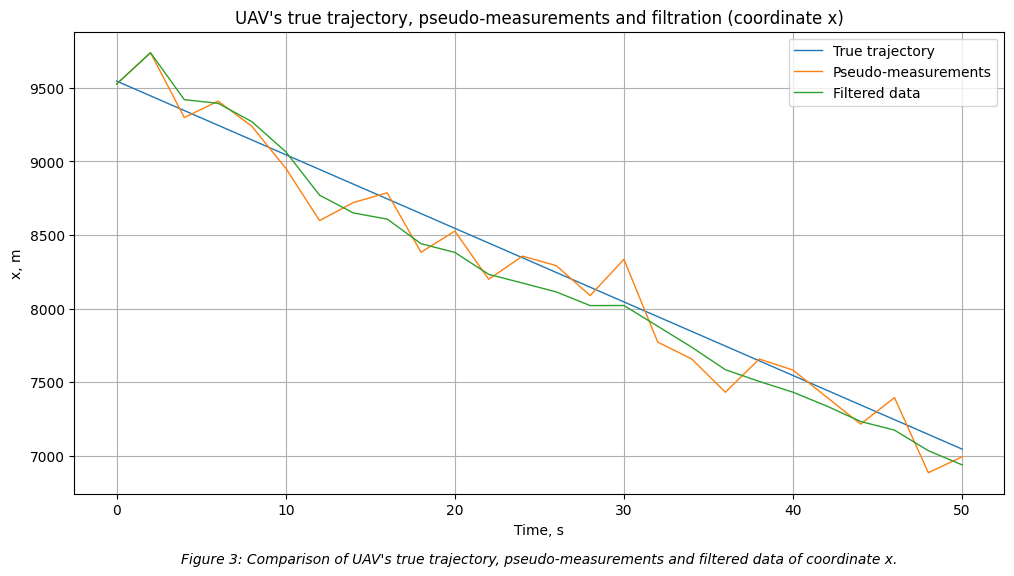

In [430]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, traj[:, 0], linewidth=1, alpha=1, label='True trajectory')
ax.plot(time, pseudo_measurements[:, 0], linewidth=1, alpha=1, label='Pseudo-measurements')
ax.plot(time, filtered_measur[:, 0], linewidth=1, alpha=1, label='Filtered data')
ax.set_xlabel('Time, s')
ax.set_ylabel('x, m')
ax.set_title("UAV's true trajectory, pseudo-measurements and filtration (coordinate x)")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 3: Comparison of UAV's true trajectory, pseudo-measurements "
"and filtered data of coordinate x.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Also lets do the same plot but for range D and azimuth $\beta$.

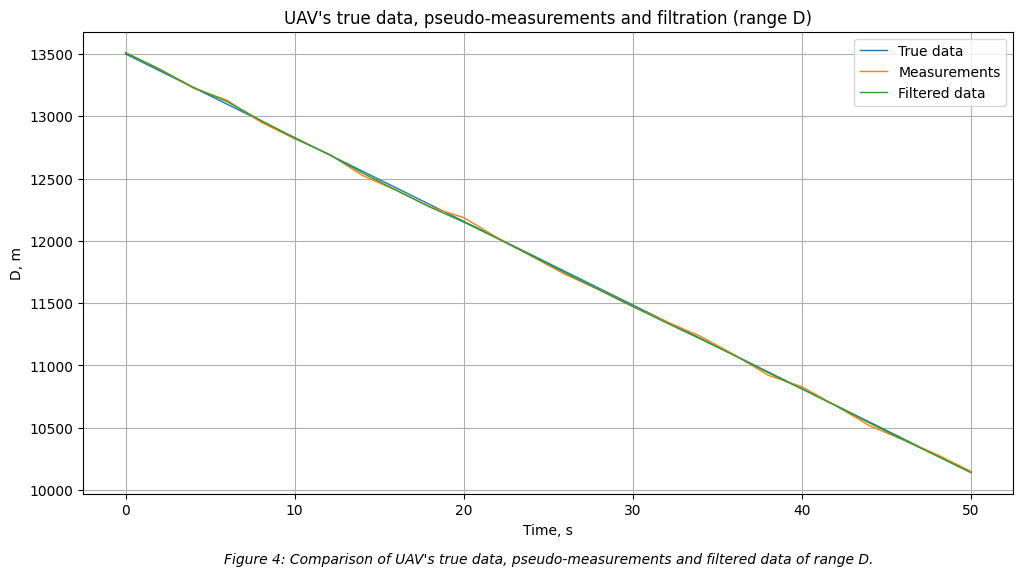

In [431]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, D, linewidth=1, alpha=1, label='True data')
ax.plot(time, measurements[:, 0], linewidth=1, alpha=1, label='Measurements')
ax.plot(time, filter.polar_filtered[:, 0], linewidth=1, alpha=1, label='Filtered data')
ax.set_xlabel('Time, s')
ax.set_ylabel('D, m')
ax.set_title("UAV's true data, pseudo-measurements and filtration (range D)")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 4: Comparison of UAV's true data, pseudo-measurements and filtered data of range D.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

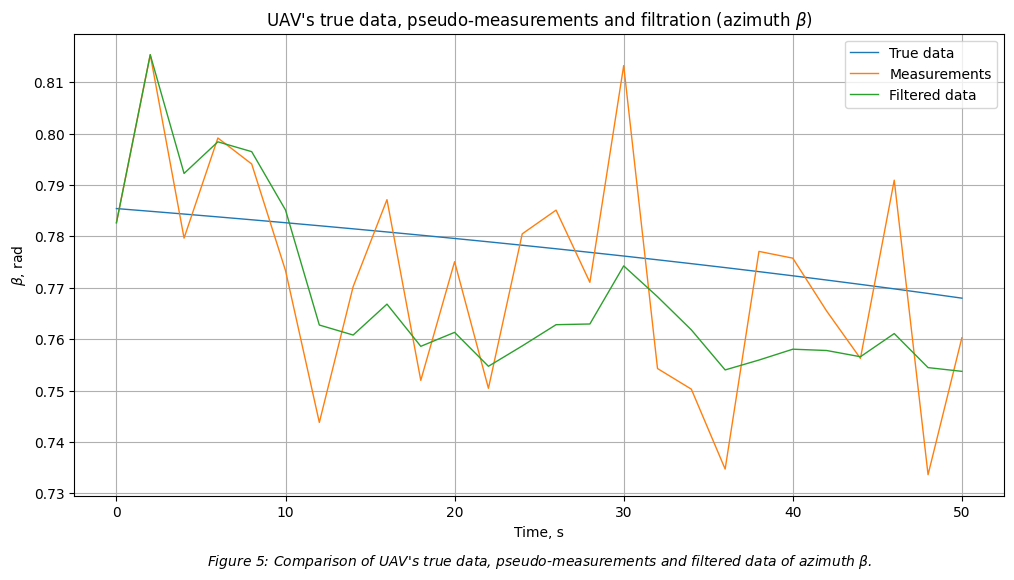

In [432]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, beta, linewidth=1, alpha=1, label='True data')
ax.plot(time, measurements[:, 1], linewidth=1, alpha=1, label='Measurements')
ax.plot(time, filter.polar_filtered[:, 1], linewidth=1, alpha=1, label='Filtered data')
ax.set_xlabel('Time, s')
ax.set_ylabel('$\\beta$, rad')
ax.set_title("UAV's true data, pseudo-measurements and filtration (azimuth $\\beta$)")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 5: Comparison of UAV's true data, pseudo-measurements and "
"filtered data of azimuth $\\beta$.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Finally, lets plot trajectory, measurements and filtered data on a polar plot.

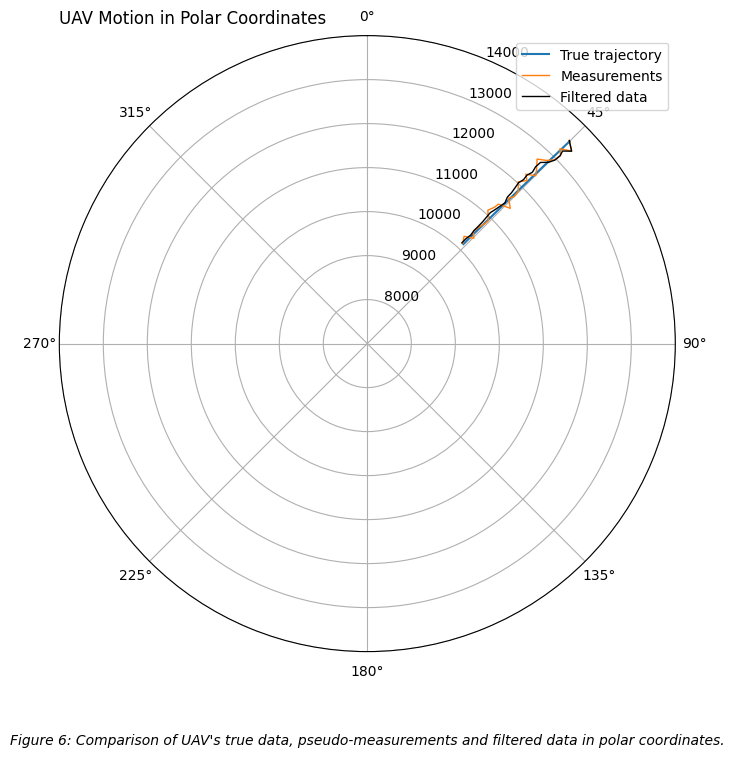

In [433]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection='polar')

ax.plot(beta, D, linewidth=1.5, label='True trajectory')
ax.plot(measurements[:, 1], measurements[:, 0], linewidth=1, label='Measurements')
ax.plot(filter.polar_filtered[:, 1], filter.polar_filtered[:, 0], color='black', linewidth=1, label='Filtered data')


ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('UAV Motion in Polar Coordinates', va='bottom', loc='left')
ax.grid(True)
ax.set_rlim(7000, 14000)
ax.legend()

ax.text(0.5, -0.15, "Figure 6: Comparison of UAV's true data, pseudo-measurements and filtered data in polar coordinates.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.show()

As you can see from Figures 3-6, Kalman filter filteres the data for both measurements and pseudo-measurements. Figure 6 is scaled in order to distinguish curves.

# Part 2. Mission Check: Stress-Testing the Filter

In this part we have to conduct a thorough analysis of the filter's performance to understand its accuracy, identify
instability zones caused by ill-conditioned coordinate transformations, and investigate why
the filter produces certain results under varying conditions.

### 1.
First of all, we run the Kalman filter for M=500 iterations and calculate the true estimation errors of predicted and filtered estimates of range D relative to $\sigma_{D}$, of redicted and filtered estimates of azimuth $\beta$ relative to $\sigma_{\beta}$.

In [434]:
M = 500

predict_D_error = np.zeros(N)
filter_D_error = np.zeros(N)

predict_beta_error = np.zeros(N)
filter_beta_error = np.zeros(N)

condition_num = np.zeros(N)

for i in range(M):
  measurements = generate_measurements(D, beta)
  pseudo_measurements = generate_pseudo_measurements(measurements)

  condition_num += np.array([max(sigma_D ** 2 / (element ** 2 * sigma_beta ** 2),
   (element ** 2 * sigma_beta ** 2) / sigma_D ** 2) for element in measurements[:, 0]])


  X_0 = np.array([40000, -20, 40000, -20])
  P_0 = 10 ** 10  * np.eye(4)
  F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
  # G = np.array([[(dt ** 2) / 2], [dt]])
  H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
  R = np.array([sigma_measur**2])
  # Q = G @ G.transpose() * sigma_acc**2
  filter = KalmanFilter(F,  H, P_0, X_0, measurements.copy(), pseudo_measurements.copy(),
                        sigma_D, sigma_beta, N)
  filtered_measur = filter.filter_all()

  predict_D_error += (D - filter.polar_predicted[:, 0]) ** 2
  filter_D_error += (D - filter.polar_filtered[:, 0]) ** 2

  predict_beta_error += (beta - filter.polar_predicted[:, 1]) ** 2
  filter_beta_error += (beta - filter.polar_filtered[:, 1]) ** 2

predict_D_error = np.sqrt(predict_D_error / M)  / sigma_D
filter_D_error = np.sqrt(filter_D_error / M ) / sigma_D

predict_beta_error = np.sqrt(predict_beta_error / M)  / sigma_beta
filter_beta_error = np.sqrt(filter_beta_error / M)  / sigma_beta

condition_num /= M

Lets plot calculated errors for range D and azimuth $\beta$.

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3044867827.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average error / $\sigma_{D}$')


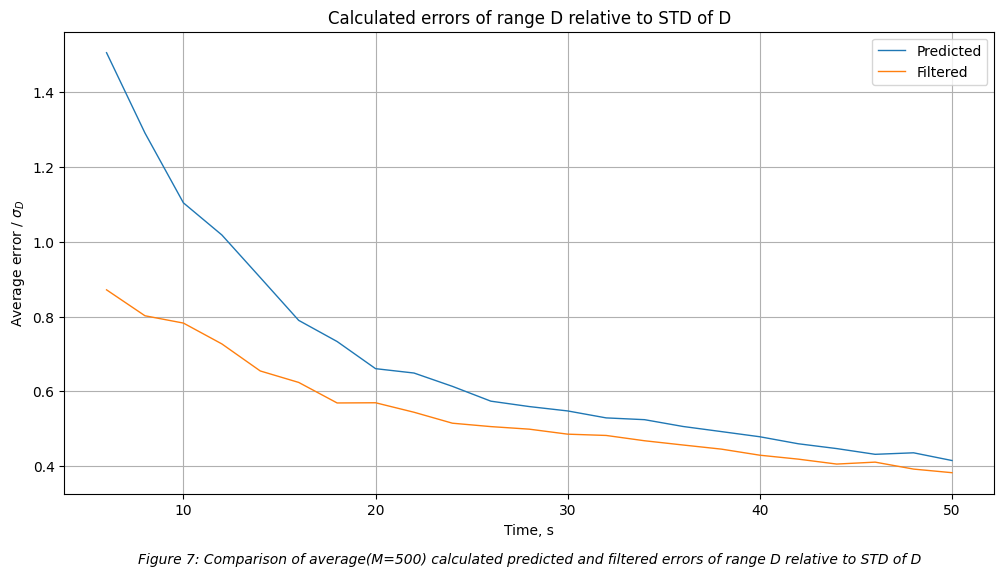

In [435]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time[3:], predict_D_error[3:], linewidth=1, alpha=1, label='Predicted')
ax.plot(time[3:], filter_D_error[3:], linewidth=1, alpha=1, label='Filtered')
ax.set_xlabel('Time, s')
ax.set_ylabel('Average error / $\sigma_{D}$')
ax.set_title("Calculated errors of range D relative to STD of D")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 7: Comparison of average(M=500) calculated predicted "
"and filtered errors of range D relative to STD of D",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-8925899.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average error / $\sigma_{\\beta}$')


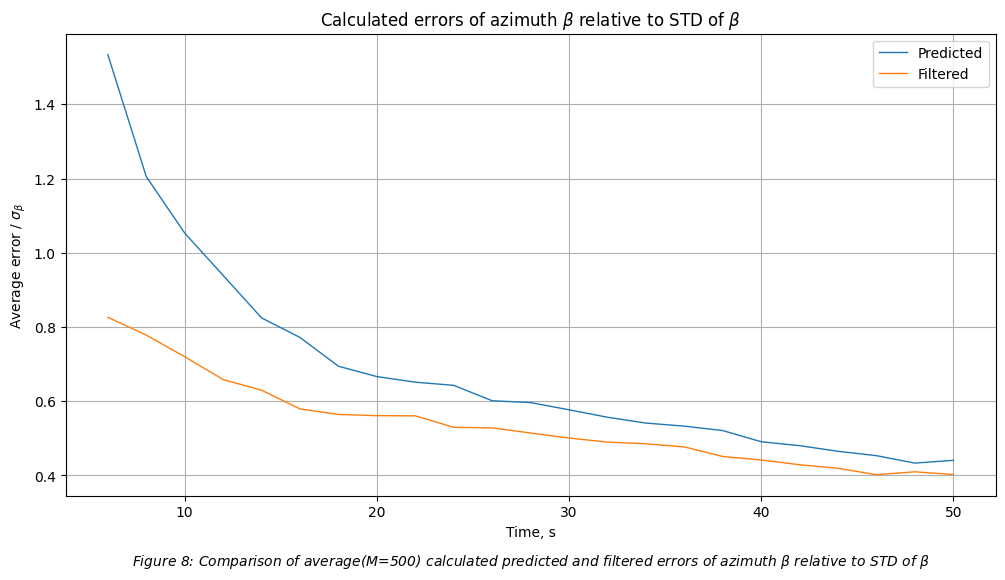

In [436]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time[3:], predict_beta_error[3:], linewidth=1, alpha=1, label='Predicted')
ax.plot(time[3:], filter_beta_error[3:], linewidth=1, alpha=1, label='Filtered')
ax.set_xlabel('Time, s')
ax.set_ylabel('Average error / $\sigma_{\\beta}$')
ax.set_title("Calculated errors of azimuth $\\beta$ relative to STD of $\\beta$")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 8: Comparison of average(M=500) calculated predicted "
"and filtered errors of azimuth $\\beta$ relative to STD of $\\beta$",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

From Figures 7-8 we can see, that for both range D and azimuth $\beta$ the ratio of predicted/filtered errors to STD converges to values, that are below 1. This means, that estimation and prediction errors are less than measurement noise, thus filter can be considered effective.

### 2.
Next step is to analyze the dependence of the true coordinate x on the true azimuth $\beta$.

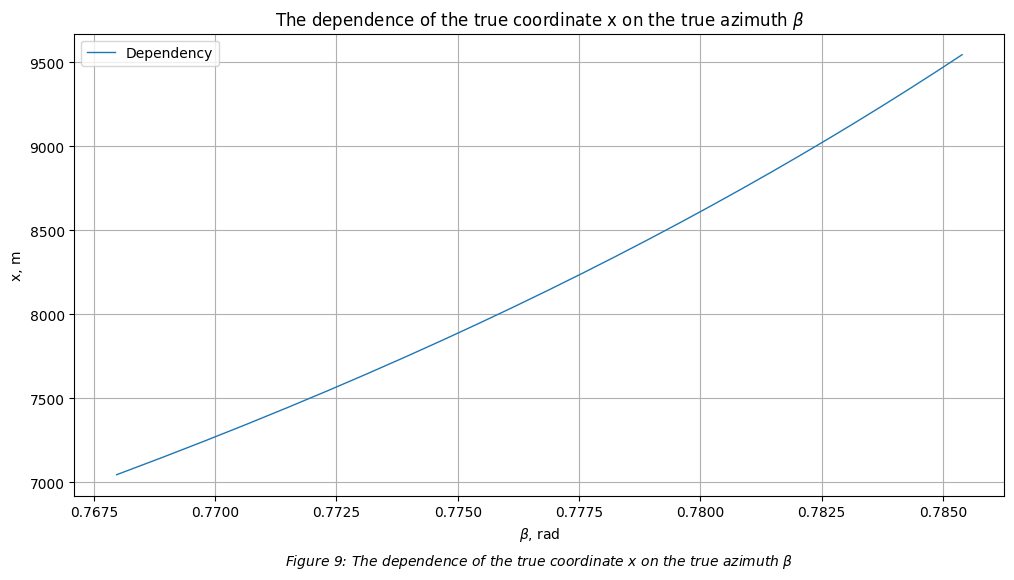

In [437]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(beta, traj[:, 0], linewidth=1, alpha=1, label='Dependency')
ax.set_xlabel('$\\beta$, rad')
ax.set_ylabel('x, m')
ax.set_title("The dependence of the true coordinate x on the true azimuth $\\beta$")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 9: The dependence of the true coordinate x on the true azimuth $\\beta$",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Even though transformation from $\beta$ to x is nonlinear, Figure 9 shows that because of big values of range D dependency of x on $\beta$ appears to look like linear, which indicates, that linearization errors are insignificant.

### 3.
Another important parameter, which has to be analyzed is the condition number of the covariance matrix R. Lets plot it with respect to time.

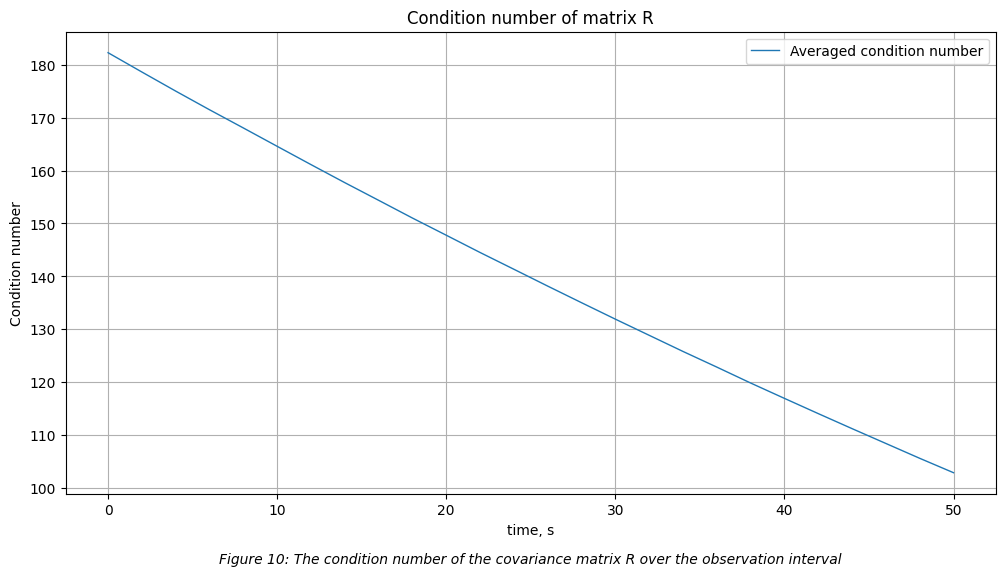

In [438]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, condition_num, linewidth=1, alpha=1, label='Averaged condition number')
# ax.plot(time[3:], filter_beta_error[3:], linewidth=1, alpha=1, label='filter')
ax.set_xlabel('time, s')
ax.set_ylabel('Condition number')
ax.set_title("Condition number of matrix R")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 10: The condition number of the covariance matrix R over the observation interval",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Figure 10 shows, that condition number dercreases over time, but for the observation period is relatively big, thus it's ill-conditioned.

### 4.
Lets also analyze how filter gain K, particulary element K(1,1), evolves throughout time.

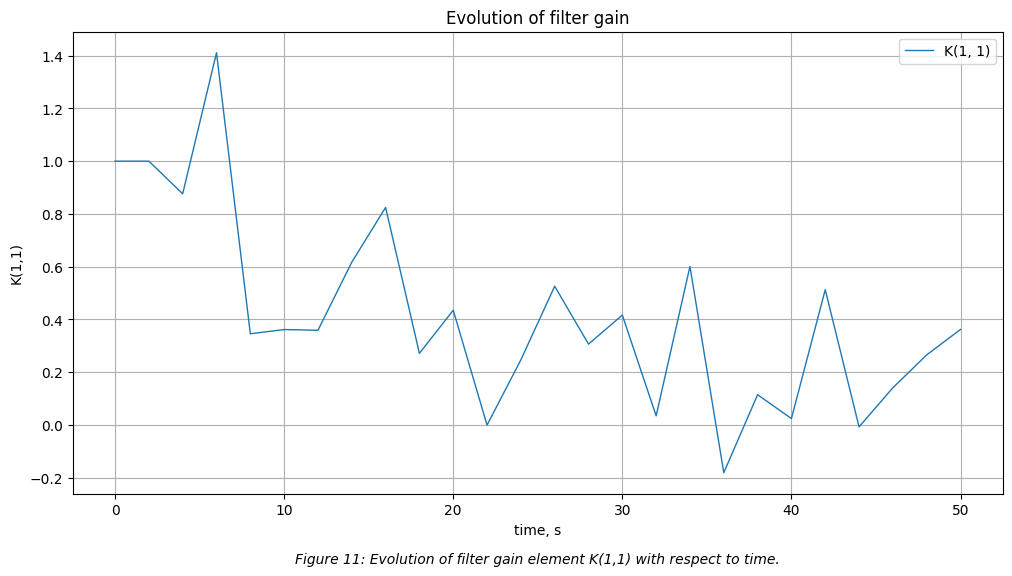

In [439]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, filter.K_arr[:, 0, 0], linewidth=1, alpha=1, label='K(1, 1)')
# ax.plot(time[3:], filter_beta_error[3:], linewidth=1, alpha=1, label='filter')
ax.set_xlabel('time, s')
ax.set_ylabel('K(1,1)')
ax.set_title("Evolution of filter gain")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 11: Evolution of filter gain element K(1,1) with respect to time.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Not all of the observations fall within range (0, 1). This is due to the fact that matrix R depends on polar measurements
that contain errors.

### 5.
Now lets run filter again over M=500 iterations, but with different initial position. This position is much closer to the observer.

In [440]:
M = 500

predict_D_error = np.zeros(N)
filter_D_error = np.zeros(N)

predict_beta_error = np.zeros(N)
filter_beta_error = np.zeros(N)

condition_num = np.zeros(N)

x_0 = np.array([3500 / np.sqrt(2), 3500 / np.sqrt(2)])
traj, vel = generate_trajectory(x_0, v_0)
D, beta = generate_observations(traj)

for i in range(M):
  measurements = generate_measurements(D, beta)
  pseudo_measurements = generate_pseudo_measurements(measurements)

  condition_num += np.array([max(sigma_D ** 2 / (element ** 2 * sigma_beta ** 2),
   (element ** 2 * sigma_beta ** 2) / sigma_D ** 2) for element in measurements[:, 0]])


  X_0 = np.array([40000, -20, 40000, -20])
  P_0 = 10 ** 10  * np.eye(4)
  F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
  # G = np.array([[(dt ** 2) / 2], [dt]])
  H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
  R = np.array([sigma_measur**2])
  # Q = G @ G.transpose() * sigma_acc**2
  filter = KalmanFilter(F,  H, P_0, X_0, measurements.copy(), pseudo_measurements.copy(),
                        sigma_D, sigma_beta, N)
  filtered_measur = filter.filter_all()

  predict_D_error += (D - filter.polar_predicted[:, 0]) ** 2
  filter_D_error += (D - filter.polar_filtered[:, 0]) ** 2

  predict_beta_error += (beta - filter.polar_predicted[:, 1]) ** 2
  filter_beta_error += (beta - filter.polar_filtered[:, 1]) ** 2

predict_D_error = np.sqrt(predict_D_error / M)  / sigma_D
filter_D_error = np.sqrt(filter_D_error / M ) / sigma_D

predict_beta_error = np.sqrt(predict_beta_error / M)  / sigma_beta
filter_beta_error = np.sqrt(filter_beta_error / M)  / sigma_beta
condition_num /= M

New motion in polar coordinates:

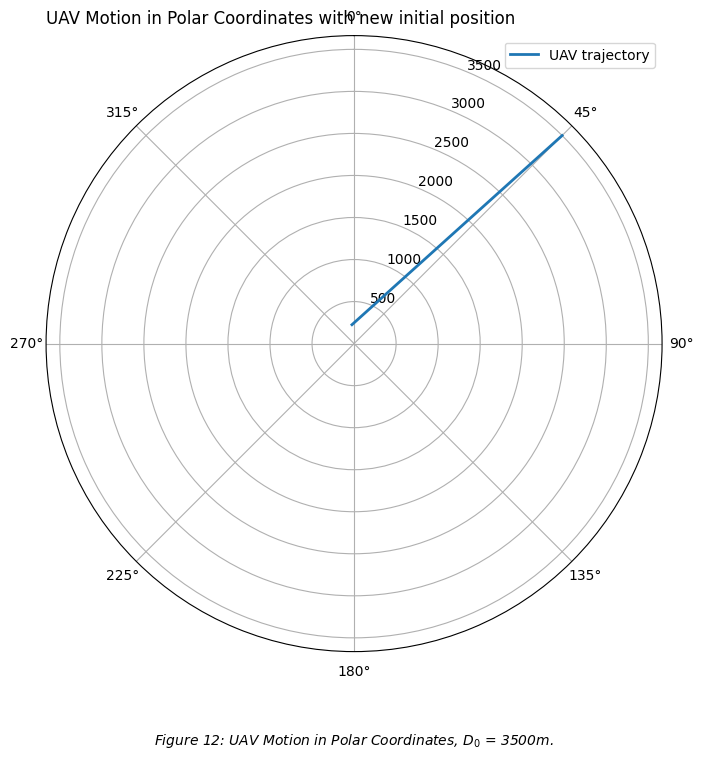

In [441]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection='polar')

ax.plot(beta, D, linewidth=2, label='UAV trajectory')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('UAV Motion in Polar Coordinates with new initial position', va='bottom', loc='left')
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 12: UAV Motion in Polar Coordinates, $D_{0}$ = 3500m.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.show()

###  6.
Lets repeat same steps as we did for previous initial conditions. First - comparison of errors for range D and azimuth $\beta$.

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-305304708.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average error / $\sigma_{D}$')


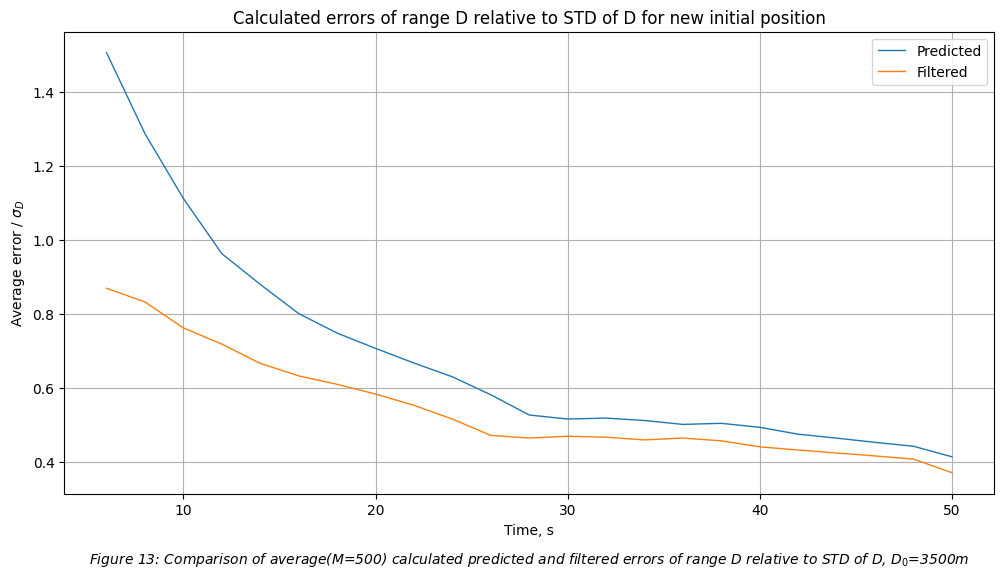

In [442]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time[3:], predict_D_error[3:], linewidth=1, alpha=1, label='Predicted')
ax.plot(time[3:], filter_D_error[3:], linewidth=1, alpha=1, label='Filtered')
ax.set_xlabel('Time, s')
ax.set_ylabel('Average error / $\sigma_{D}$')
ax.set_title("Calculated errors of range D relative to STD of D for new initial position")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 13: Comparison of average(M=500) calculated predicted and "
"filtered errors of range D relative to STD of D, $D_{0}$=3500m",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2317053922.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average error / $\sigma_{\\beta}$')


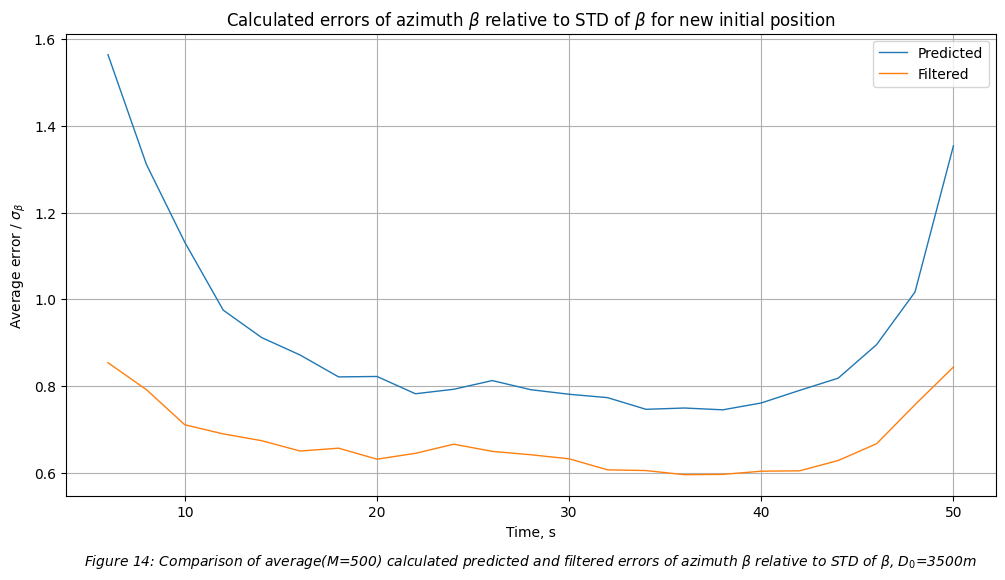

In [443]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time[3:], predict_beta_error[3:], linewidth=1, alpha=1, label='Predicted')
ax.plot(time[3:], filter_beta_error[3:], linewidth=1, alpha=1, label='Filtered')
ax.set_xlabel('Time, s')
ax.set_ylabel('Average error / $\sigma_{\\beta}$')
ax.set_title("Calculated errors of azimuth $\\beta$ relative to STD of $\\beta$ for new initial position")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 14: Comparison of average(M=500) calculated predicted "
"and filtered errors of azimuth $\\beta$ relative to STD of $\\beta$, $D_{0}$=3500m",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Comparing to previous runs, the behaviour has changed: for range D on Figure 13 we can see, that calculated errors are still more accureate, than measurements, but for azimuth $\beta$ on Figure 14 at the end curves start to raise, which leads to conclusion, that after couple more steps calculated errors are going to be bigger than measurement ones for azimuth.

### 7.
Now lets plot another dependence of x on $\beta$.

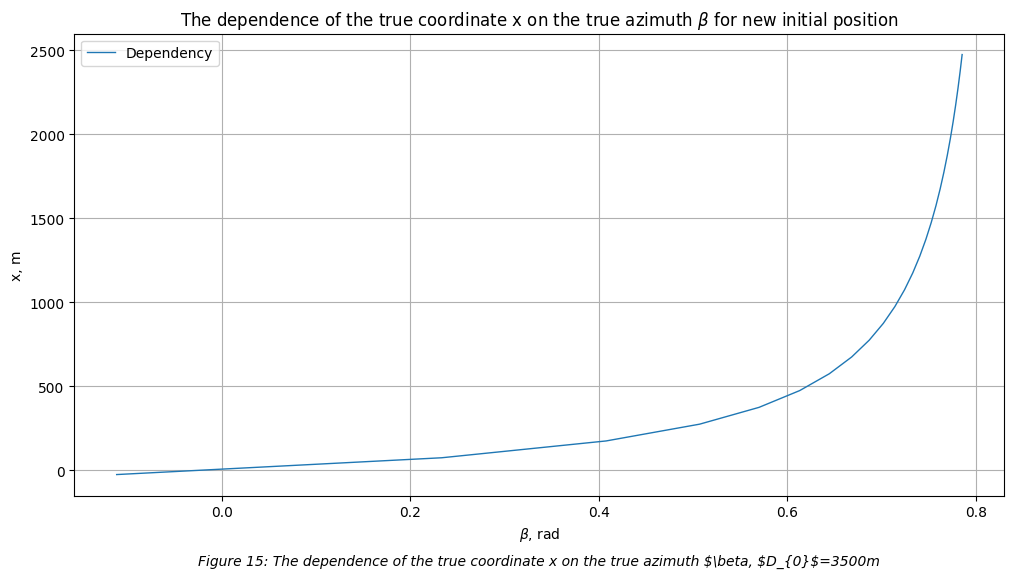

In [444]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(beta, traj[:, 0], linewidth=1, alpha=1, label='Dependency')
ax.set_xlabel('$\\beta$, rad')
ax.set_ylabel('x, m')
ax.set_title("The dependence of the true coordinate x on the true azimuth $\\beta$ for new initial position")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 15: The dependence of the true coordinate x on the true azimuth $\\beta, $D_{0}$=3500m",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Figure 15 shows that dependency is not linear at all. Therefore linearization errors are significant.

### 8.
Now - condition number.

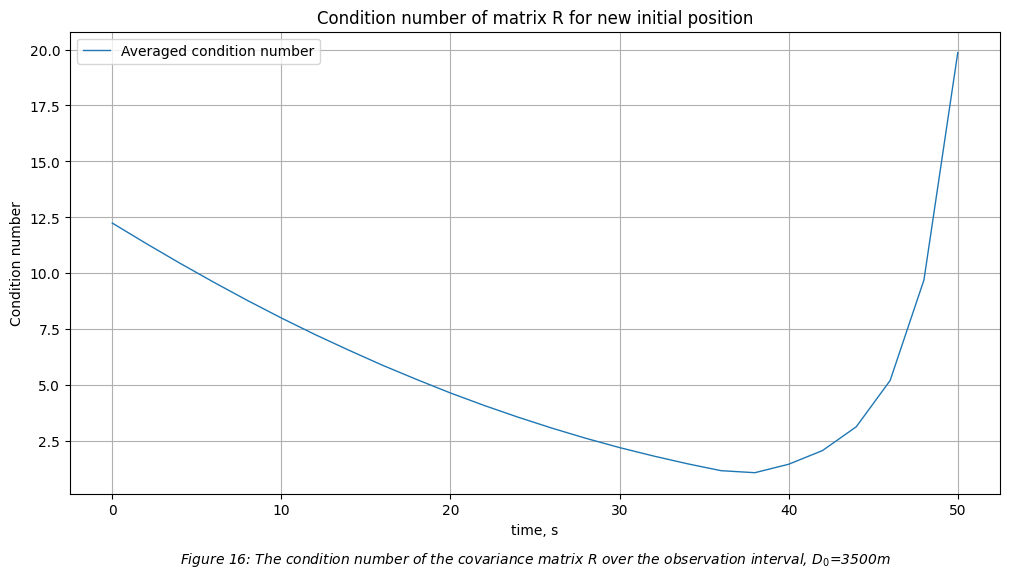

In [445]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, condition_num, linewidth=1, alpha=1, label='Averaged condition number')
# ax.plot(time[3:], filter_beta_error[3:], linewidth=1, alpha=1, label='filter')
ax.set_xlabel('time, s')
ax.set_ylabel('Condition number')
ax.set_title("Condition number of matrix R for new initial position")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 16: The condition number of the covariance matrix R "
"over the observation interval, $D_{0}$=3500m",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

From Figure 16 we can see, that condition number reaches it's minimum (which is 1) and then starts to grow rapidly, making system less stable.

### 9. Mid conclusion.
When the object is at a great distance from the observer, the relationship between the x coordinate and the azimuth $\beta$ is close to linear.Linearization errors are minimal, since the coordinate transformation is well approximated by the linear model. Therefore - high accuracy and errors fall within measurement noise range.

On the other side, when an object approaches the radar, the non-linearity of the coordinate transformation becomes significant. The linear approximation becomes less accurate, which leads to increased filtering errors.

Therefore, it is crucial to choose starting position.

### 10.
Repeating items 4-7 but for different variances of measurements D and $\beta$.

In [446]:
M = 500

predict_D_error = np.zeros(N)
filter_D_error = np.zeros(N)

predict_beta_error = np.zeros(N)
filter_beta_error = np.zeros(N)

condition_num = np.zeros(N)

x_0 = np.array([3500 / np.sqrt(2), 3500 / np.sqrt(2)])
traj, vel = generate_trajectory(x_0, v_0)
D, beta = generate_observations(traj)

sigma_D = 50
sigma_beta = 0.0015

for i in range(M):
  measurements = generate_measurements(D, beta)
  pseudo_measurements = generate_pseudo_measurements(measurements)

  condition_num += np.array([max(sigma_D ** 2 / (element ** 2 * sigma_beta ** 2),
   (element ** 2 * sigma_beta ** 2) / sigma_D ** 2) for element in measurements[:, 0]])


  X_0 = np.array([40000, -20, 40000, -20])
  P_0 = 10 ** 10  * np.eye(4)
  F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
  # G = np.array([[(dt ** 2) / 2], [dt]])
  H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
  R = np.array([sigma_measur**2])
  # Q = G @ G.transpose() * sigma_acc**2
  filter = KalmanFilter(F,  H, P_0, X_0, measurements.copy(), pseudo_measurements.copy(),
                        sigma_D, sigma_beta, N)
  filtered_measur = filter.filter_all()

  predict_D_error += (D - filter.polar_predicted[:, 0]) ** 2
  filter_D_error += (D - filter.polar_filtered[:, 0]) ** 2

  predict_beta_error += (beta - filter.polar_predicted[:, 1]) ** 2
  filter_beta_error += (beta - filter.polar_filtered[:, 1]) ** 2

predict_D_error = np.sqrt(predict_D_error / M)  / sigma_D
filter_D_error = np.sqrt(filter_D_error / M ) / sigma_D

predict_beta_error = np.sqrt(predict_beta_error / M)  / sigma_beta
filter_beta_error = np.sqrt(filter_beta_error / M)  / sigma_beta
condition_num /= M

Plotting filter gain.

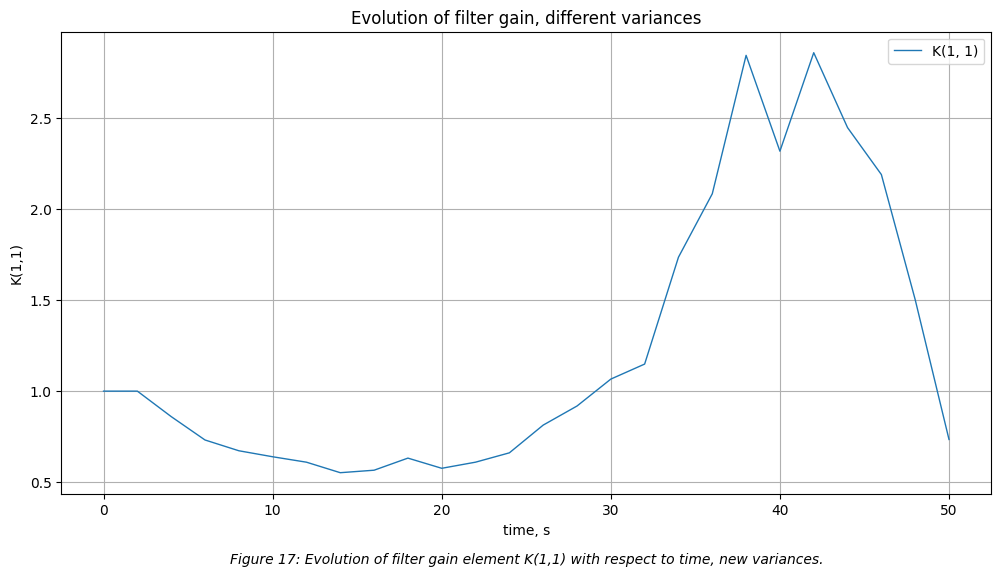

In [447]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, filter.K_arr[:, 0, 0], linewidth=1, alpha=1, label='K(1, 1)')
# ax.plot(time[3:], filter_beta_error[3:], linewidth=1, alpha=1, label='filter')
ax.set_xlabel('time, s')
ax.set_ylabel('K(1,1)')
ax.set_title("Evolution of filter gain, different variances")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 17: Evolution of filter gain element K(1,1) with respect to time, new variances.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Plotting errors.

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2137890284.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average error / $\sigma_{D}$')


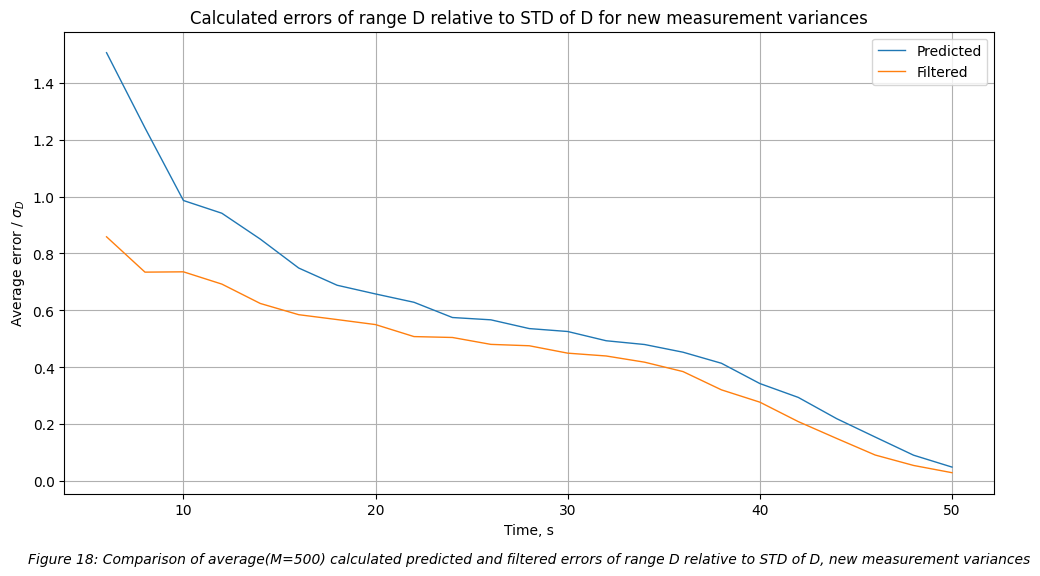

In [448]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time[3:], predict_D_error[3:], linewidth=1, alpha=1, label='Predicted')
ax.plot(time[3:], filter_D_error[3:], linewidth=1, alpha=1, label='Filtered')
ax.set_xlabel('Time, s')
ax.set_ylabel('Average error / $\sigma_{D}$')
ax.set_title("Calculated errors of range D relative to STD of D for new measurement variances")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 18: Comparison of average(M=500) calculated predicted "
"and filtered errors of range D relative to STD of D, new measurement variances",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1817004207.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average error / $\sigma_{\\beta}$')


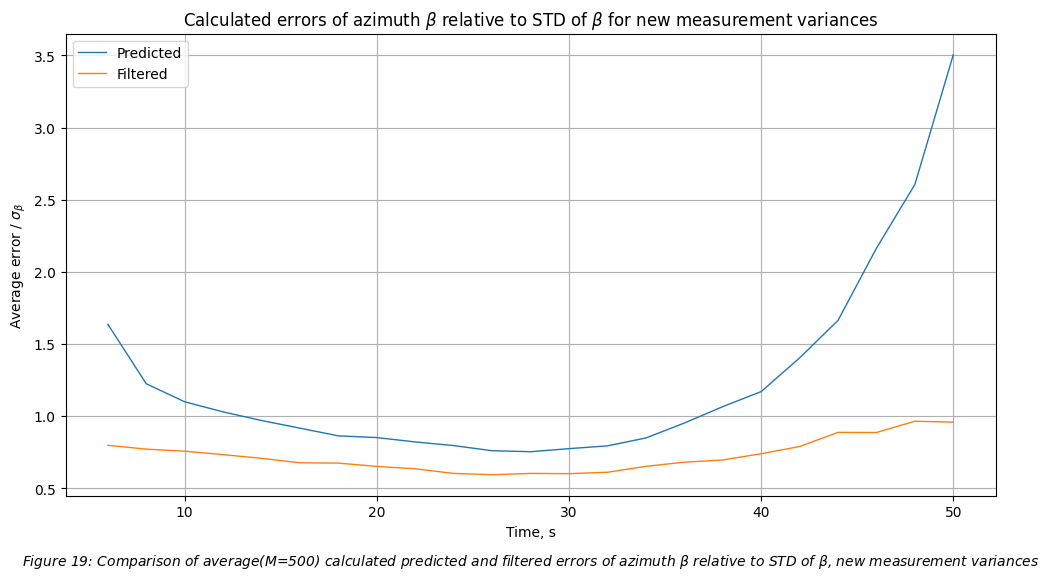

In [449]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time[3:], predict_beta_error[3:], linewidth=1, alpha=1, label='Predicted')
ax.plot(time[3:], filter_beta_error[3:], linewidth=1, alpha=1, label='Filtered')
ax.set_xlabel('Time, s')
ax.set_ylabel('Average error / $\sigma_{\\beta}$')
ax.set_title("Calculated errors of azimuth $\\beta$ relative to STD of $\\beta$ for new measurement variances")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 19: Comparison of average(M=500) calculated predicted "
"and filtered errors of azimuth $\\beta$ relative to STD of $\\beta$, new measurement variances",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Because range variance increased and azimuth variance decreased, we can see that there is a better convergence for D, but not optimal solution for $\beta$.

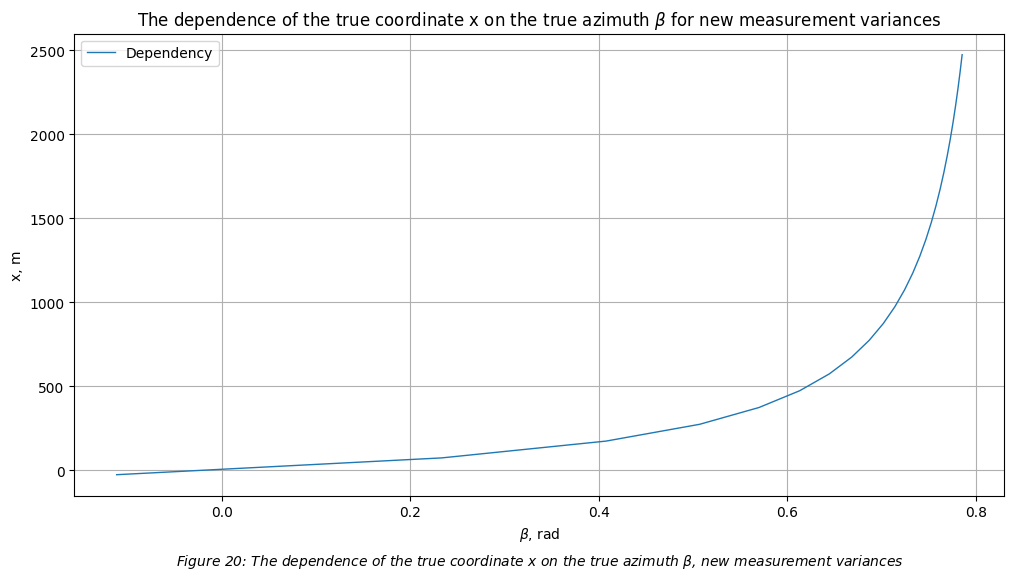

In [450]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(beta, traj[:, 0], linewidth=1, alpha=1, label='Dependency')
ax.set_xlabel('$\\beta$, rad')
ax.set_ylabel('x, m')
ax.set_title("The dependence of the true coordinate x on the true azimuth $\\beta$ for new measurement variances")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 20: The dependence of the true coordinate x on the "
"true azimuth $\\beta$, new measurement variances",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Figure 20 shows, that dependency is still nonlinear at all.

Finally, condition number:

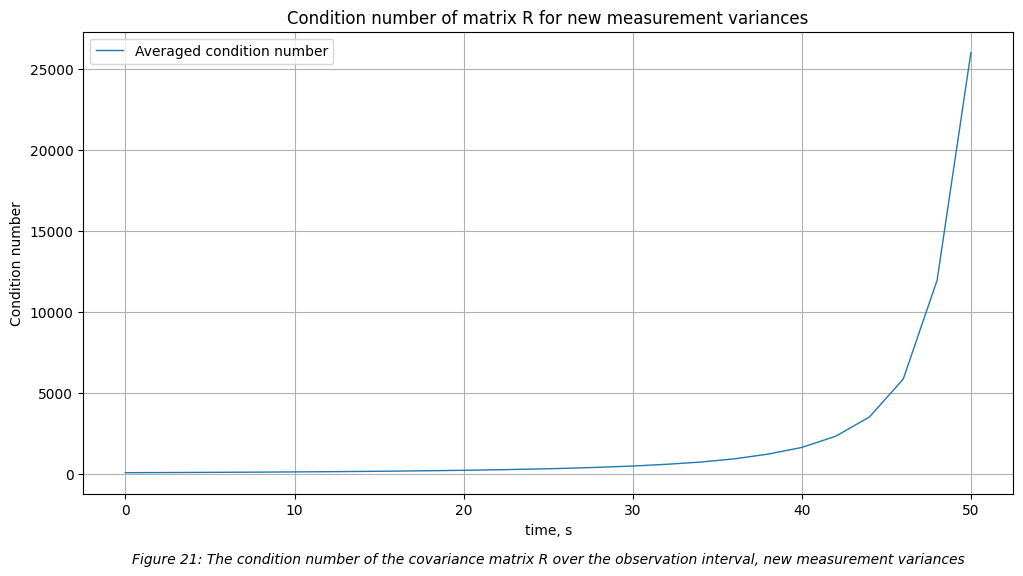

In [451]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, condition_num, linewidth=1, alpha=1, label='Averaged condition number')
# ax.plot(time[3:], filter_beta_error[3:], linewidth=1, alpha=1, label='filter')
ax.set_xlabel('time, s')
ax.set_ylabel('Condition number')
ax.set_title("Condition number of matrix R for new measurement variances")
ax.grid(True)
ax.legend()

ax.text(0.5, -0.15, "Figure 21: The condition number of the covariance matrix "
"R over the observation interval, new measurement variances",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

# Conclusion

This project is devoted to developing a tracking filter for a moving UAV where radar measurements are in polar coordinates
while the motion model is in Cartesian coordinates and analyzing filter's performance.

In **Part 1** we designed Kalman filter, which used pseudo-measurements, gathered by generated measurements of range and azimtuh, to filter data. From Figure 1 we saw, that initial position is far from radar, thus azimuth changes insignificantly during observation time.

In **Part 2** we conducted a thorough analysis of the filters performance to understand its accuracy, identified
instability zones caused by ill-conditioned coordinate transformations, and investigated why
the filter produces certain results under varying conditions.
We conducted calculations for different initial positions and measurement variances. The main results are shown on Figures 8-21. The main conclusions, that we made from that figures are:

1) It is importnat to choose initial position. When the object is at a great distance from the observer, the relationship between the x coordinate and the azimuth $\beta$ is close to linear.Linearization errors are minimal, since the coordinate transformation is well approximated by the linear model. Therefore - high accuracy and errors fall within measurement noise range.

2) Variance affetcs optimality of filter, as, for example, with the decrease of azimuth measurement noise, calculated estimation error became bigger, than measurement noise, which makes filter not optimal.

Finally, answering item 12 from **Part 2**, navigation system becomes blind and the filter diverges primarily during close-range scenarios when the UAV is close to the radar. The main problem is ill-conditioning of the measurement covariance matrix R(not linearization errors). As range decreases, R becomes severely ill-conditioned, amplifying noise and causing instability. To overcome this problem, we can use alternative coordinate systems, regularization techniques, and nonlinear filters like EKF.